
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 感情分析: 畳み込みニューラル ネットワークの使用

:label: `sec_sentiment_cnn`

 :numref: `chap_cnn`では、隣接するピクセルなどの局所的な特徴に適用される 2 次元 CNN を使用して 2 次元画像データを処理するメカニズムを調査しました。 CNN はもともとコンピューター ビジョン用に設計されましたが、自然言語処理にも広く使用されています。簡単に言えば、あらゆるテキストシーケンスを 1 次元の画像として考えてください。このようにして、1 次元 CNN はテキスト内の $n$-gram などの局所的な特徴を処理できます。

このセクションでは、 *textCNN*モデルを使用して、単一のテキストを表現するための CNN アーキテクチャを設計する方法を示します :cite: `Kim.2014` 。感情分析用に GloVe 事前トレーニングを備えた RNN アーキテクチャを使用する :numref: `fig_nlp-map-sa-rnn`と比較すると、:numref: `fig_nlp-map-sa-cnn`の唯一の違いはアーキテクチャの選択です。 

![](../img/nlp-map-sa-cnn.svg) :label: `fig_nlp-map-sa-cnn`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)


## 1次元の畳み込み

モデルを紹介する前に、1 次元の畳み込みがどのように機能するかを見てみましょう。これは相互相関演算に基づく 2 次元畳み込みの特殊なケースにすぎないことに留意してください。 

![](http://d2l.ai/_images/conv1d.svg) :ラベル: `fig_conv1d`

 :numref: `fig_conv1d`に示すように、1 次元の場合、畳み込みウィンドウは入力テンソル全体で左から右にスライドします。スライディング中、畳み込みウィンドウの特定の位置に含まれる入力サブテンソル (例: :numref: `fig_conv1d`の $0$ と $1$) とカーネル テンソル (例: :numref: `fig_conv1d`の $1$ と $2$) が要素ごとに乗算されます。 。これらの乗算の合計により、出力テンソルの対応する位置にある単一のスカラー値 (たとえば、 :numref: `fig_conv1d`の $0\times1+1\times2=2$) が得られます。

次の`corr1d`関数で 1 次元の相互相関を実装します。入力テンソル`X`とカーネル テンソル`K`を指定すると、出力テンソル`Y`を返します。


In [2]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y


:numref: `fig_conv1d`から入力テンソル`X`とカーネル テンソル`K`を構築して、上記の 1 次元相互相関実装の出力を検証できます。


In [3]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])


複数のチャネルを持つ 1 次元入力の場合、コンボリューション カーネルには同じ数の入力チャネルが必要です。次に、各チャネルに対して、入力の 1 次元テンソルとコンボリューション カーネルの 1 次元テンソルに対して相互相関演算を実行し、すべてのチャネルの結果を合計して 1 次元出力テンソルを生成します。 :numref: `fig_conv1d_channel` 3 つの入力チャネルを使用した 1 次元の相互相関演算を示します。 

![](../img/conv1d-channel.svg) :label: `fig_conv1d_channel`

複数の入力チャネルに対して 1 次元の相互相関演算を実装し、 :numref: `fig_conv1d_channel`で結果を検証できます。


In [4]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])


複数入力チャネルの 1 次元相互相関は、単一入力チャネルの 2 次元相互相関と同等であることに注意してください。説明すると、 :numref: `fig_conv1d_channel`の複数入力チャネル 1 次元相互相関の等価形式は、 :numref: `fig_conv1d_2d`の単一入力チャネル 2 次元相互相関です。ここで、コンボリューション カーネルの高さはは入力テンソルと同じである必要があります。 

![](../img/conv1d-2d.svg) :ラベル: `fig_conv1d_2d`

 :numref: `fig_conv1d`と :numref: `fig_conv1d_channel`の両方の出力には、チャネルが 1 つだけあります。 :numref: `subsec_multi-output-channels`で説明されている複数の出力チャネルによる 2 次元の畳み込みと同じように、1 次元の畳み込みに対して複数の出力チャネルを指定することもできます。

## 最大超過時間プール

同様に、プーリングを使用して、タイム ステップ全体で最も重要な特徴としてシーケンス表現から最高の値を抽出できます。 textCNN で使用される*max-over-time プーリングは、* 1 次元のグローバル max-pooling :cite: `Collobert.Weston.Bottou.ea.2011`と同様に機能します。各チャネルが異なるタイム ステップで値を保存するマルチチャネル入力の場合、各チャネルの出力はそのチャネルの最大値になります。 max-over-time プーリングでは、異なるチャネルで異なる数のタイム ステップが許可されることに注意してください。

##  textCNN モデル

textCNN モデルは、1 次元の畳み込みと最大経時プーリングを使用して、事前トレーニングされた個々のトークン表現を入力として取得し、ダウンストリーム アプリケーション用にシーケンス表現を取得して変換します。

 $d$ 次元ベクトルで表される $n$ トークンを持つ単一のテキスト シーケンスの場合、入力テンソルの幅、高さ、チャネル数はそれぞれ $n$、$1$、$d$ になります。 textCNN モデルは、次のように入力を出力に変換します。
1. 複数の 1 次元コンボリューション カーネルを定義し、入力に対して個別にコンボリューション演算を実行します。異なる幅の畳み込みカーネルは、異なる数の隣接するトークン間で局所的な特徴をキャプチャできます。
1. すべての出力チャネルで最大経時プーリングを実行し、すべてのスカラー プーリング出力をベクトルとして連結します。
1. 全結合層を使用して、連結されたベクトルを出力カテゴリに変換します。ドロップアウトはオーバーフィッティングを軽減するために使用できます。 

![](http://d2l.ai/_images/textcnn.svg):label: `fig_conv1d_textcnn`

 :numref: `fig_conv1d_textcnn` textCNN のモデル アーキテクチャを具体的な例で示しています。入力は 11 個のトークンを含む文で、各トークンは 6 次元ベクトルで表されます。したがって、幅 11 の 6 チャネル入力があります。幅 2 と 4 の 2 つの 1 次元畳み込みカーネルを、それぞれ 4 と 5 の出力チャネルで定義します。これらは幅 $11-2+1=10$ の 4 つの出力チャネルと幅 $11-4+1=8$ の 5 つの出力チャネルを生成します。これら 9 つのチャネルの幅は異なりますが、最大経時プーリングにより連結された 9 次元ベクトルが得られ、最終的にバイナリセンチメント予測用の 2 次元出力ベクトルに変換されます。

### モデルの定義

textCNN モデルを次のクラスに実装します。 :numref: `sec_sentiment_rnn`の双方向 RNN モデルと比較すると、リカレント層を畳み込み層に置き換えるだけでなく、トレーニング可能な重みを持つ 1 つと固定重みを持つ 2 つの埋め込み層の 2 つの埋め込み層も使用します。


In [5]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs


textCNN インスタンスを作成しましょう。カーネル幅が 3、4、5 の 3 つの畳み込み層があり、すべて 100 の出力チャネルがあります。


In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);


### 事前学習済みの単語ベクトルの読み込み

:numref: `sec_sentiment_rnn`と同様に、事前トレーニングされた 100 次元の GloVe 埋め込みを初期化されたトークン表現として読み込みます。これらのトークン表現 (埋め込み重み) は、 `embedding`でトレーニングされ、 `constant_embedding`で修正されます。


In [7]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False


### モデルのトレーニングと評価

これで、感情分析用に textCNN モデルをトレーニングできるようになりました。


loss 0.067, train acc 0.978, test acc 0.869
2827.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


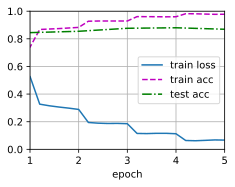

In [8]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


以下では、トレーニングされたモデルを使用して、2 つの単純な文の感情を予測します。


In [9]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'


## まとめ
- 1 次元 CNN は、テキスト内の $n$-gram などの局所的な特徴を処理できます。
- 複数入力チャネルの 1 次元相互相関は、単一入力チャネルの 2 次元相互相関と同等です。
- 最大経時プーリングにより、異なるチャネルで異なる数のタイム ステップが可能になります。
-  textCNN モデルは、1 次元畳み込み層と最大経時プーリング層を使用して、個々のトークン表現をダウンストリーム アプリケーション出力に変換します。

## 演習
1. ハイパーパラメータを調整し、:numref: `sec_sentiment_rnn`とこのセクションでセンチメント分析の 2 つのアーキテクチャを分類精度や計算効率などで比較します。
1.  :numref: `sec_sentiment_rnn`の演習で導入された方法を使用して、モデルの分類精度をさらに向上させることはできますか?
1. 入力表現に位置エンコーディングを追加します。分類精度は向上しますか?



[ディスカッション](https://discuss.d2l.ai/t/1425)
